<a href="https://colab.research.google.com/github/viosmedical/aiwork/blob/main/ecg_autoencoder_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Collab Notebook
##### 04 July 2025, Ganesh Subramaniam
##### This Notebook to learn about Autoencoders for ECG Anomoly detection

### Reference
https://www.kaggle.com/code/ohseokkim/dectecting-anomaly-using-autoencoder

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [4]:
!pip install umap-learn
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=fe402ce0f4af73c3e9dae3c37df700ac4e557a6d988cfc49c36477b70af1370d
  Stored in directory: /root/.cache/pip/wheels/82/d8/73/e9eb3334baaad795ff0278363ff1aca7568bdf2793e452a527
Successfully built umap


In [5]:
import os
# os.environ['NUMBA_CUDA_DRIVER'] = '/usr/lib64/nvidia/libcuda.so' # Add or Remove this line as per error
#import umap
#import umap.plot
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [6]:
!pip install  pandas matplotlib datashader bokeh holoviews scikit-image colorcet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 26.9 MB/s eta 0:00:00


#### About ECG Dataset
This dataset contains the ECG readings of patients. Each row corresponds to a single complete ECG of a patient. Every single ECG is composed of 140 data points(readings). Columns 0-139 contain the ECG data point for a particular patient. These are floating point numbers. A label field shows whether the ECG is normal (1) or abnormal (0).

### Utility Functions

In [7]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)

    roc_auc = roc_auc_score(y_test, pred_proba)
    print('confusion matrix')
    print(confusion)

    # ROC-AUC print
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

### Load ECG Dataset

In [8]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head().style.set_properties(**{'background-color': 'black',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,-0.493223,-0.463052,-0.301644,-0.232734,-0.125055,-0.153943,-0.024357,-0.065609,0.034999,0.061935,0.071195,0.123925,0.103124,0.225228,0.128683,0.302483,0.257276,0.196352,0.179383,0.244729,0.341217,0.328204,0.406042,0.446605,0.424068,0.481512,0.477844,0.624083,0.574585,0.598013,0.564592,0.607979,0.620635,0.656253,0.684748,0.694273,0.665584,0.575796,0.638135,0.614917,0.569083,0.468576,0.442818,0.468274,0.432493,0.407958,0.418623,0.362531,0.410959,0.471666,0.372167,0.337875,0.221405,0.273997,0.298664,0.263564,0.342564,0.419505,0.586607,0.860624,1.173345,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.000000
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,-0.206160,-0.224480,-0.048684,-0.019621,0.094805,0.116786,0.185186,0.230526,0.138027,0.244426,0.271695,0.259003,0.269202,0.127065,0.202073,0.255983,0.153115,0.210216,0.191082,0.190927,0.210510,0.207108,0.204888,0.200865,0.346920,0.348002,0.254537,0.331975,0.356690,0.349930,0.430380,0.467502,0.486063,0.403188,0.478956,0.397392,0.464120,0.451795,0.361361,0.379831,0.342785,0.399107,0.387508,0.255703,0.284034,0.284993,0.250108,0.173036,0.149423,0.141685,0.222261,0.172847,0.150779,0.176566,0.280942,0.489939,0.660889,0.893193,1.026997,1.202394,1.557410,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.000000
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,-0.438023,-0.436248,-0.400114,-0.134987,-0.239347,-0.120244,-0.001971,0.285000,0.315646,0.107364,0.109521,0.158078,0.291898,0.261294,0.188407,0.140651,0.263365,0.287207,0.314317,0.177942,0.138290,0.321069,0.458168,0.251916,0.261353,0.277488,0.298793,0.459075,0.419147,0.520509,0.537761,0.603211,0.475634,0.521693,0.735248,0.729541,0.718523,0.498433,0.545441,0.604827,0.521296,0.394381,0.405020,0.597563,0.531130,0.377651,0.467701,0.457569,0.341116,0.407913,0.459127,0.403937,0.298191,0.46110

### Checking Target Imbalance

In [9]:
colors = ['gold', 'mediumturquoise']
labels = ['Normal','Abnormal']
values = dataframe[140].value_counts()/dataframe[140].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=0.1)))
fig.update_layout(
    title_text="ECG dataset",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()

### Splitting Dataset

In [10]:
# The last column contains the labels (0 for abnormal, 1 for normal)
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

# This is the core of the splitting process. It uses the train_test_split function from the sklearn.model_selection module
# to divide the data and labels into training and testing sets.
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

### Preprocessing

In [11]:
# scale the training and testing data values to a range between 0 and 1 and then convert to tf.float32 data type.
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [12]:
# prepare the training and testing data by converting the labels to a boolean type and then separating the normal and anomalous data points into distinct variables
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

print("the length of train :",len(train_labels))
print("the length of test :",len(test_labels))

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

the length of train : 3998
the length of test : 1000


### Plot the Normal ECG

Text(0.5, 1.0, 'A Normal ECG')

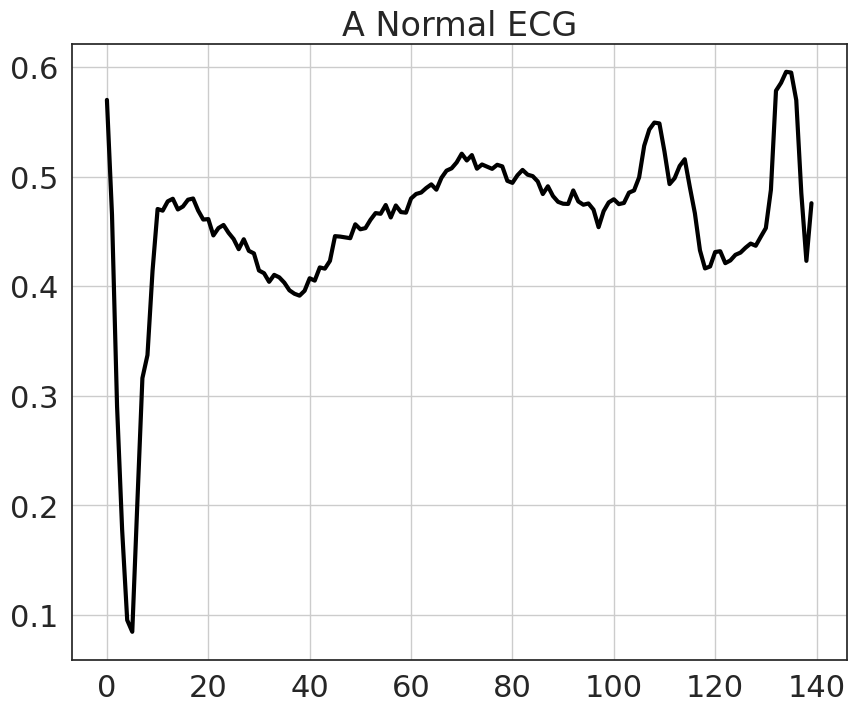

In [13]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), normal_train_data[0],color='black',linewidth=3.0)
plt.title("A Normal ECG")

### Plot the abnormal ECG

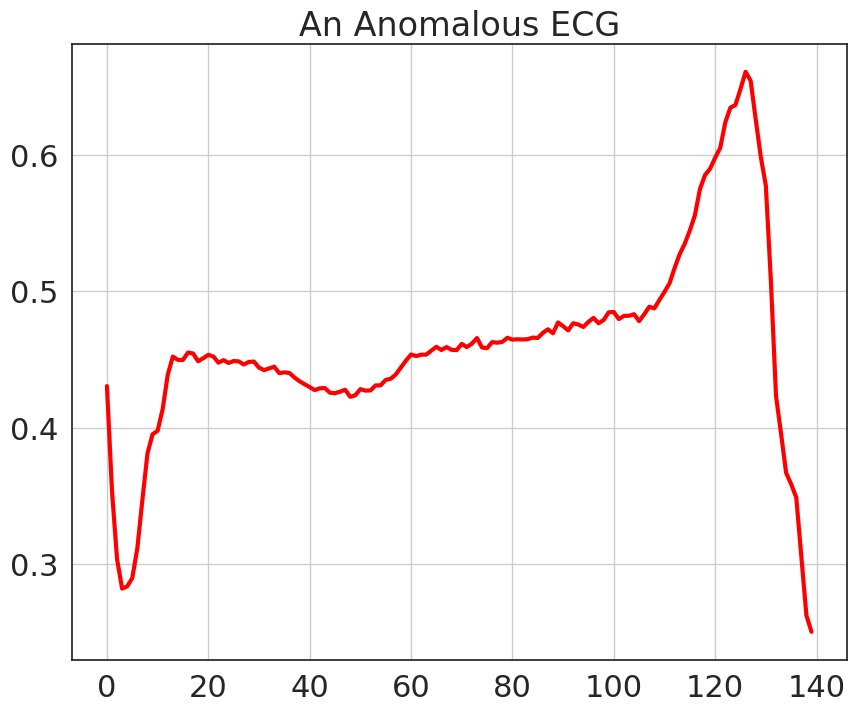

In [14]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0],color='red',linewidth=3.0)
plt.title("An Anomalous ECG")
plt.show()

### Modelling

In [15]:
# Inherits keras Model as AnomalyDetector, which is an autoencoder designed for anomaly detection
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [16]:
autoencoder.compile(optimizer='adam', loss='mae')

### Training

In [17]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 0.0631 - val_loss: 0.0539
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0571 - val_loss: 0.0527
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0556 - val_loss: 0.0511
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0533 - val_loss: 0.0489
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0497 - val_loss: 0.0467
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0454 - val_loss: 0.0451
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0411 - val_loss: 0.0438
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0374 - val_loss: 0.0418
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0338 - val_loss: 0.0401
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0311 - val_loss: 0.0391
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0290 - val_loss: 0.0382
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0270 - val_loss: 0.0371


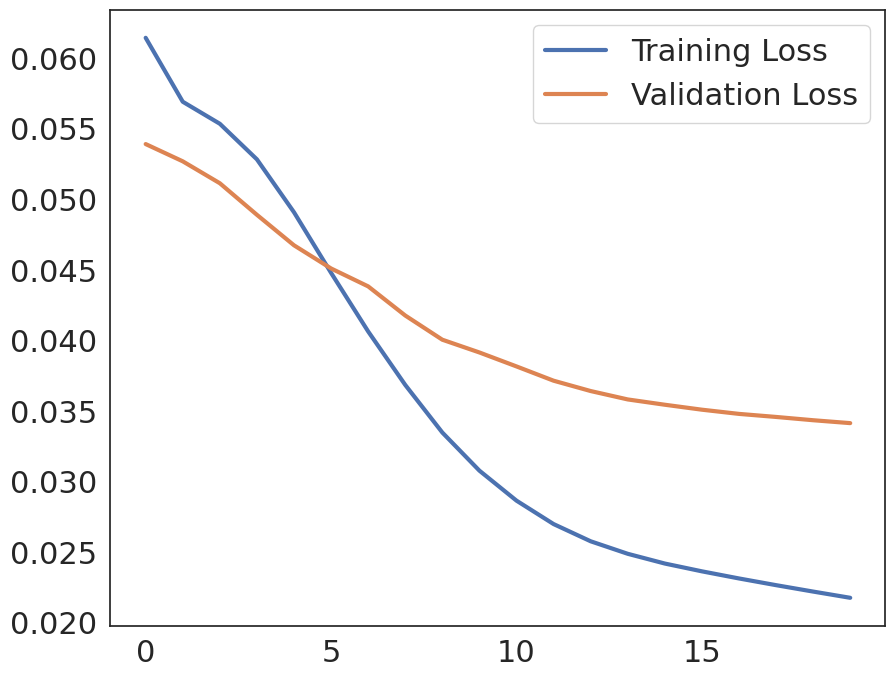

In [18]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

If the reconstruction error is greater than one standard deviation from the normal training example, classify the ECG as abnormal. First, let's plot the normal ECG of the training set, the reconstruction after being encoded and decoded by the autoencoder, and the reconstruction error

### Testing using normal data

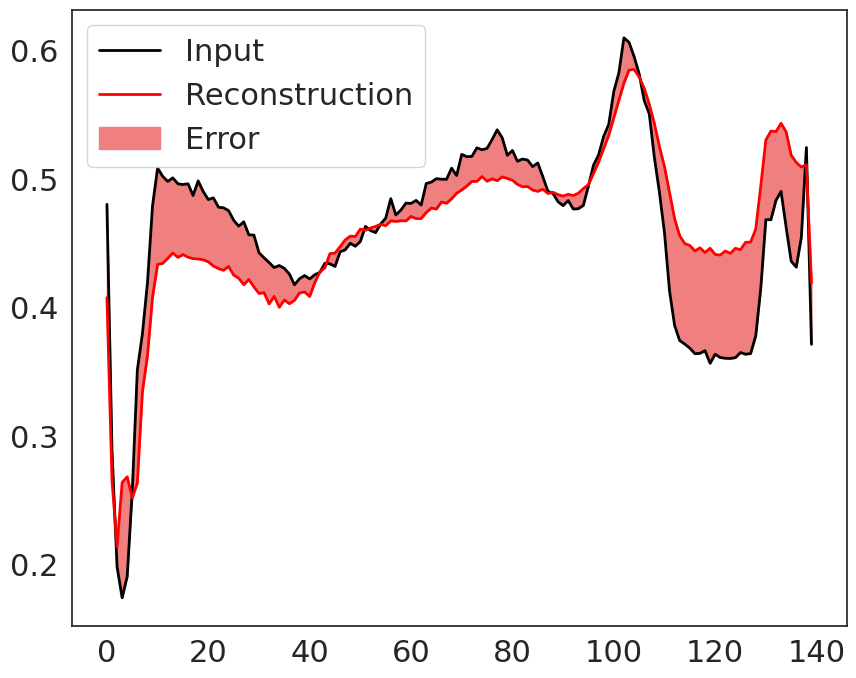

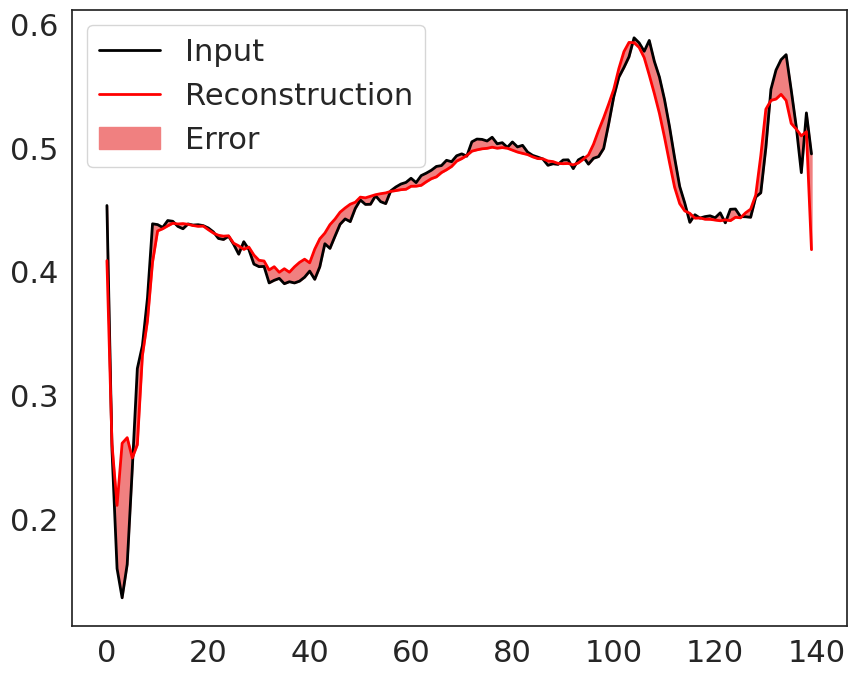

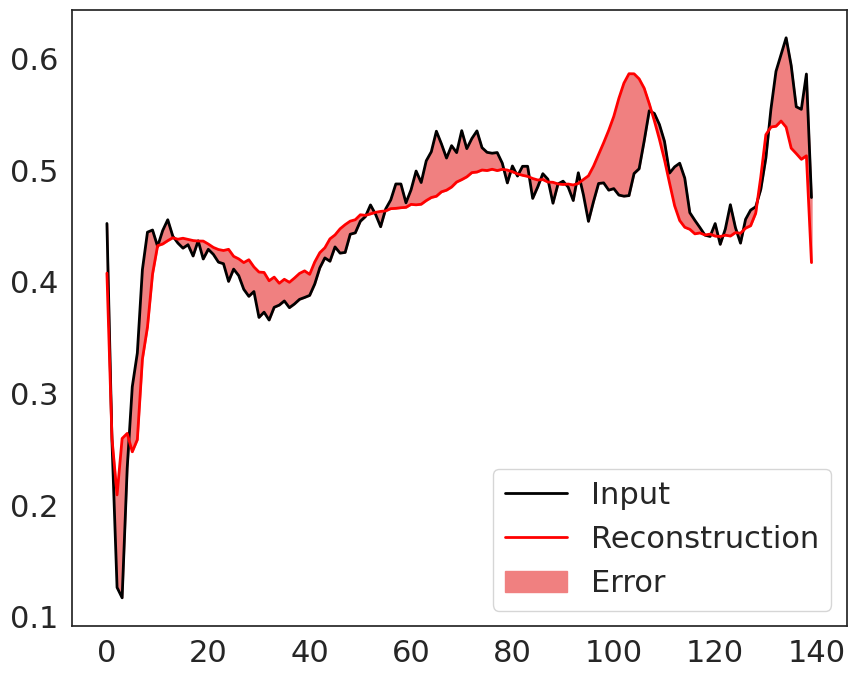

In [19]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0,3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.plot(normal_test_data[i], 'black',linewidth=2)
    plt.plot(decoded_imgs[i], 'red',linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], normal_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [20]:
encoded_imgs_normal = pd.DataFrame(encoded_imgs)
encoded_imgs_normal['label'] = 1

### Testing using abnormal data

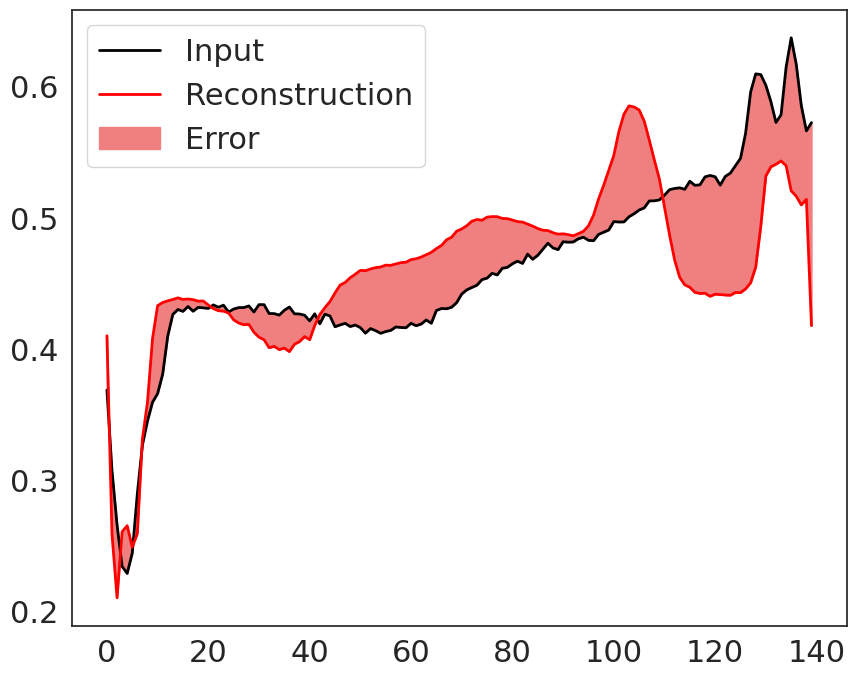

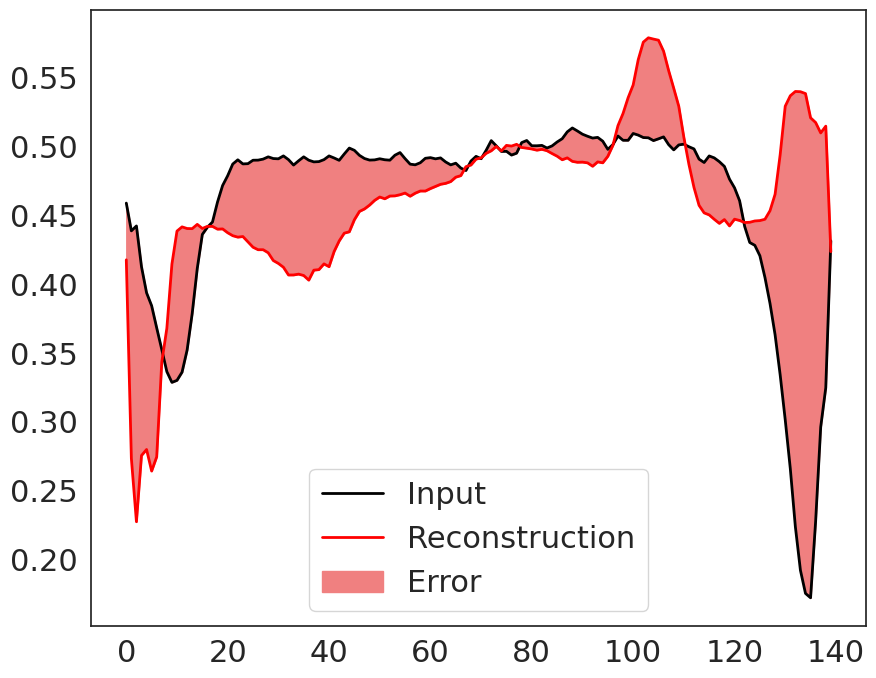

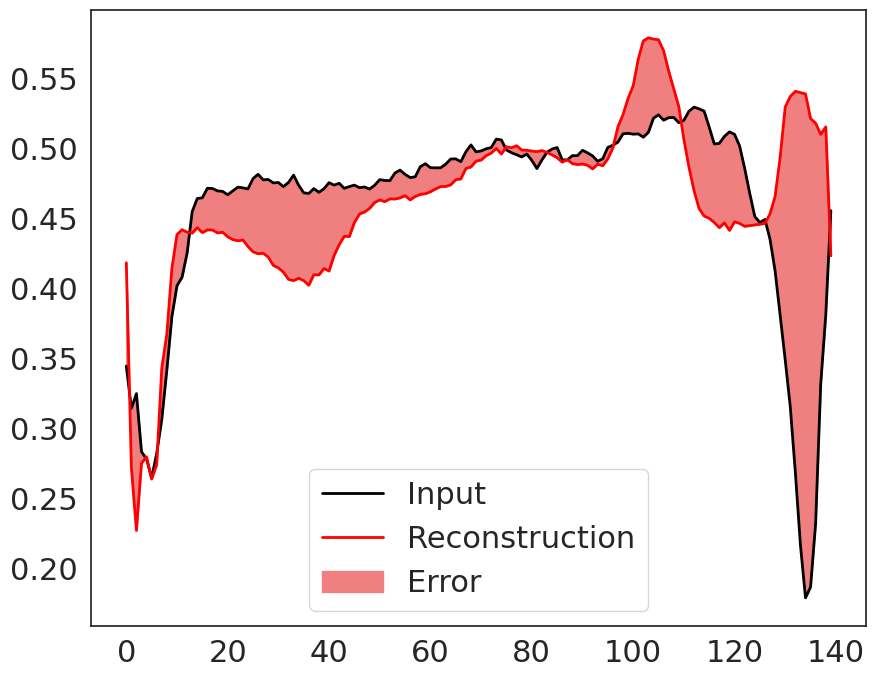

In [21]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0,3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.plot(anomalous_test_data[i], 'black',linewidth=2)
    plt.plot(decoded_imgs[i], 'red',linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], anomalous_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [22]:
encoded_imgs_abnormal = pd.DataFrame(encoded_imgs)
encoded_imgs_abnormal['label'] = 0

### Detecting Anomaly

In [23]:
all_encoded = pd.concat([encoded_imgs_normal,encoded_imgs_abnormal])

In [24]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [25]:
np.mean(train_loss)

np.float32(0.021513335)

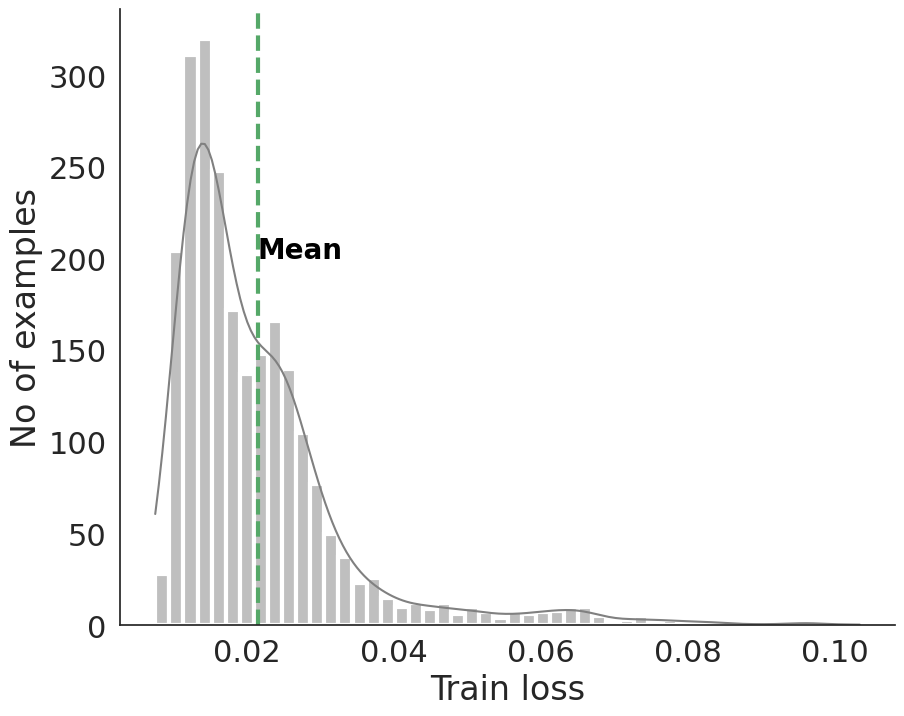

In [26]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Mean", horizontalalignment='left',
         size='small', color='black', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

In [27]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033841603


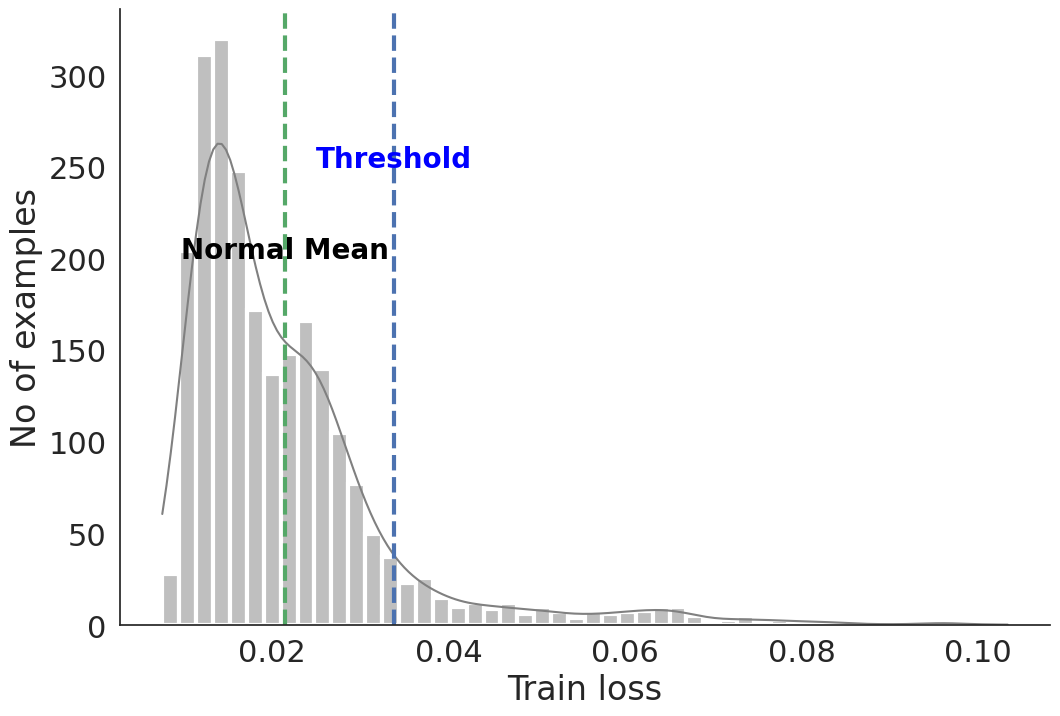

In [28]:
#  generates a histogram of the reconstruction errors from your normal training data and visualizes two important thresholds on it: the mean reconstruction error and the anomaly detection threshold.
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

Examining reconstruction errors for unusual examples in the test set reveals that most of them have reconstruction errors greater than the threshold(blue-dotted line=0.033).

In [29]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


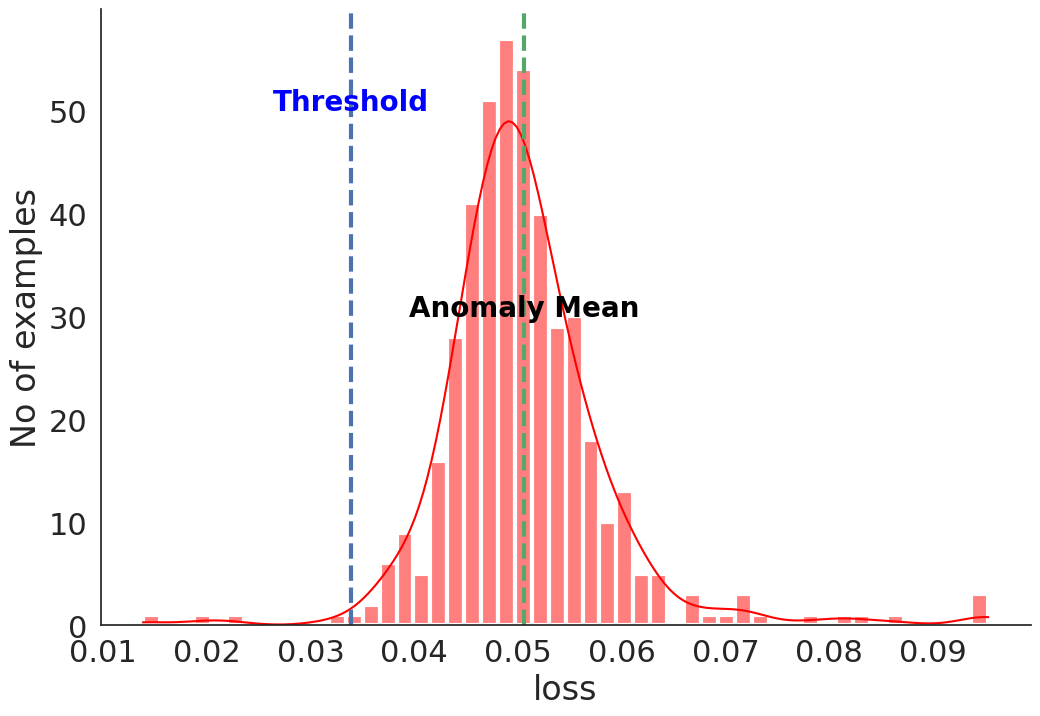

In [30]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 30, "Anomaly Mean", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.text(threshold, 50, "Threshold", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

If the reconstruction error is greater than the threshold(blue-dotted line), classify the ECG as abnormal.

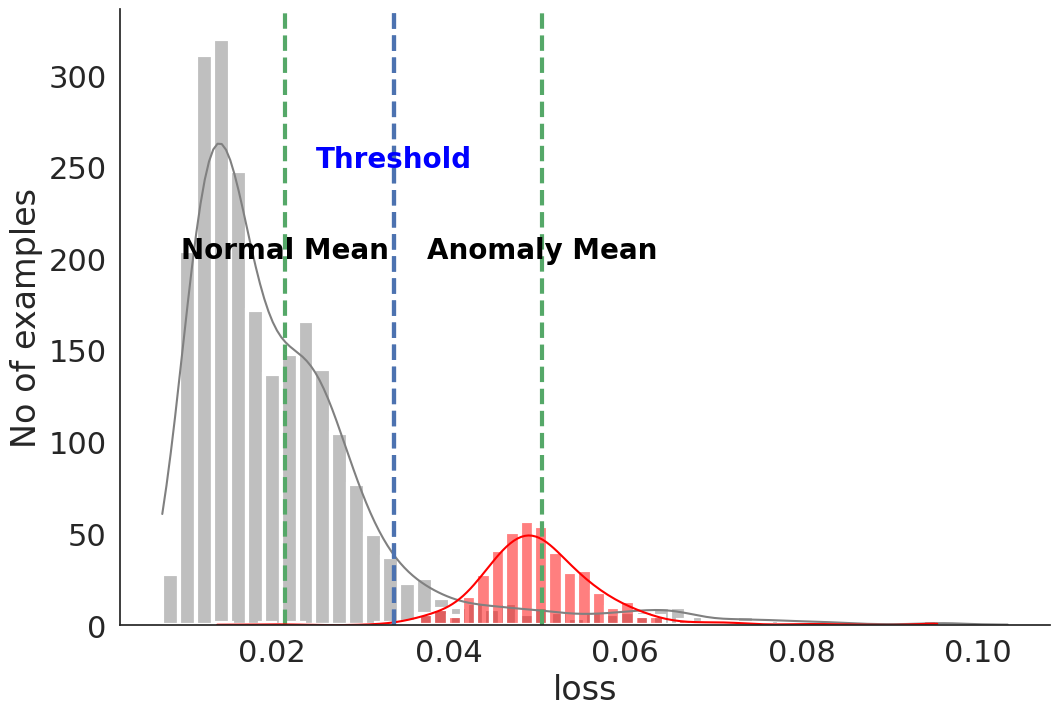

In [31]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')

sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 200, "Anomaly Mean", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

Looking at the picture above, it seems that the threshold was set by considering the Normal and Anomaly distributions well. In particular, it seems that recall is more important than precision for abnomaly detection. In actual application, it may be necessary to consider fine-tuning the threshold

### Predicting

In [32]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [33]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429


confusion matrix
[[436   4]
 [ 53 507]]
accuracy: 0.9430, precision: 0.9922, recall: 0.9054,    F1: 0.9468, AUC:0.9481


<Axes: >

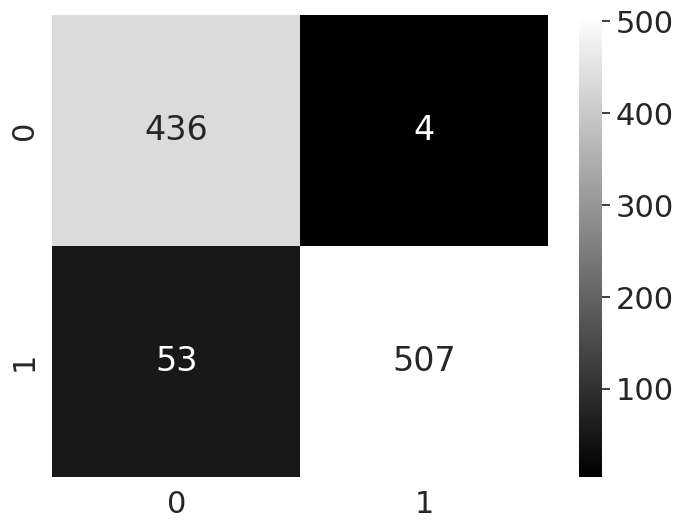

In [34]:
confusion_matrix = get_clf_eval(test_labels,preds,preds)
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
sns.heatmap(confusion_matrix, cmap = 'gist_yarg_r',annot = True, fmt='d')